## Logistic Regression Assignment: TITANIC survival

#### Importing libraries and data

In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

In [3]:
# Load the datsets
df = pd.read_csv('train.csv')
X_test_final =pd.read_csv('test.csv')

# Creating copy of datasets
df_1 = df.copy(deep=True)
df_2 = df.copy(deep=True)
X_test_final_1 = X_test_final.copy(deep=True)

In [4]:
# Ignoring warnings for future code changes
import warnings
warnings.filterwarnings("ignore")

#### Exploratory data analysis : data cleaning and optimisation, features selection.

* 'Survived' contains binary values: 0=dead, 1=alive 
* Passenger Id and Name do not contain information useful in this case but they just would add too many categories, so I will drop those 2 features. 
* 'Cabin' has too many missing values which I dont think I can efficiently fill, so I will drop this feature.
* 'Embarked' has 2 null values and 3 different categories (the 3 ports people could embark from) I will fill the 2 null values. It is not adding many dimensions to the model. 
* I am filling missing age and fare with median

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# Handling missing values
#I will fill age an dfare with the median and drop the 2 lines with missing Embarked values
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)

In [8]:
# ANALYSING MISSING VALUES IN'EMBARKED' (2 null values are present)

# Checking 'Embarked' categories
unique_values = df['Embarked'].unique()
print("Unique Values using unique():", unique_values)

# Counting entries for each category
S = df.loc[df['Embarked'] == 'S'].count()[0]
C = df.loc[df['Embarked'] == 'C'].count()[0]
Q = df.loc[df['Embarked'] == 'Q'].count()[0]
new_line= '\n'
print(f'S={S}{new_line}C={C}{new_line}Q={Q}')

# Adding 2 missing values as 'S', the biggest category
df = df.fillna({'Embarked' : 'S'})

Unique Values using unique(): ['S' 'C' 'Q' nan]
S=644
C=168
Q=77


In [76]:
# Double checking for missing values after preprocessing
df.isnull().sum()

Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [10]:
# Checking 'Pclass' categories: only 3, they won't add many dimensions
unique_values = df['Pclass'].unique()
print("Unique Values using unique():", unique_values)

Unique Values using unique(): [3 1 2]


In [11]:
# ONE-HOT CODING
# Hot-Encoding the Categorical Columns to transform them in numerical
df = pd.get_dummies(df, columns=['Sex'], drop_first=True, dtype = 'int')
df = pd.get_dummies(df, columns=['Embarked'], dtype = 'int')

In [12]:
# DROP UNWANTED FEATURES
columns_to_drop = ['PassengerId', 'Name', 'Cabin', 'Ticket']
df = df.drop(columns=columns_to_drop)

In [13]:
# Using a function to decribe and inspection the data set

def profile_data(data):

    return pd.concat(
        [
            pd.Series(data.dtypes, name ="Dtype"),
        # count
            pd.Series(data.count(), name = "Count"),
            pd.Series(data.isnull().sum(), name = "NA count"),
            pd.Series(data.nunique(),       name = "Count unique"),
        # stats
            pd.Series(data.min(),           name = "Min"),
            pd.Series(data.max(),           name = "Max"),
            pd.Series(data.mean(),          name = "Mean"),
            pd.Series(data.median(),        name = "Median"),
            pd.Series(data.mode().iloc[0], name="Mode")
        ],
        axis = 1
    )
    
profile_df = profile_data(df)
profile_df

,Dtype,Count,NA count,Count unique,Min,Max,Mean,Median,Mode
Survived,int64,891,0,2,0.00,1.0000,0.383838,0.0000,0.00
Pclass,int64,891,0,3,1.00,3.0000,2.308642,3.0000,3.00
Age,float64,891,0,88,0.42,80.0000,29.361582,28.0000,28.00
SibSp,int64,891,0,7,0.00,8.0000,0.523008,0.0000,0.00
Parch,int64,891,0,7,0.00,6.0000,0.381594,0.0000,0.00
Fare,float64,891,0,248,0.00,512.3292,32.204208,14.4542,8.05
Sex_male,int32,891,0,2,0.00,1.0000,0.647587,1.0000,1.00
Embarked_C,int32,891,0,2,0.00,1.0000,0.188552,0.0000,0.00
Embarked_Q,int32,891,0,2,0.00,1.0000,0.086420,0.0000,0.00
Embarked_S,int32,891,0,2,0.00,1.0000,0.725028,1.0000,1.00


#### Data visualisation
* 'Gender' count using sns.countplot()
* 'Survived' count using sns.histplot()
* 'Survived' vs 'Sex' with sns.barplot()
* 'Survived' vs 'Pclass', with sns.barplot()
* 'Age' vs 'Plass' by 'Sex' with sns.boxplot()
* 'Age' vs 'Pclass by 'Survived' with sns.boxplot()
*  A heatmap for corr()
* 'Age' versus 'Sex' by 'Survived' with sns.stripplot()
*  Grid graph with 'Survived' versus predictors barplots, with pd.cut() used on 'Age' to make visualisation more meaningful (reducing bars)

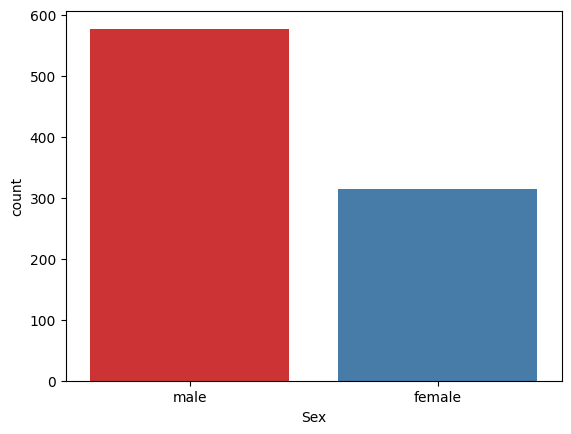

In [15]:
sns.countplot(x='Sex', data=df_1, palette = 'Set1')
plt.show()

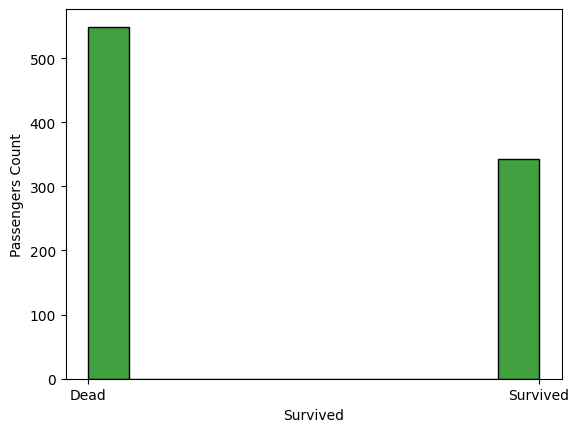

In [16]:

fig, ax = plt.subplots()
sns.histplot(x=df_1['Survived'], kde = False, color='green')
plt.xticks(ticks=np.arange(0,2,1), labels=["Dead", "Survived"])
plt.ylabel('Passengers Count')
plt.show()

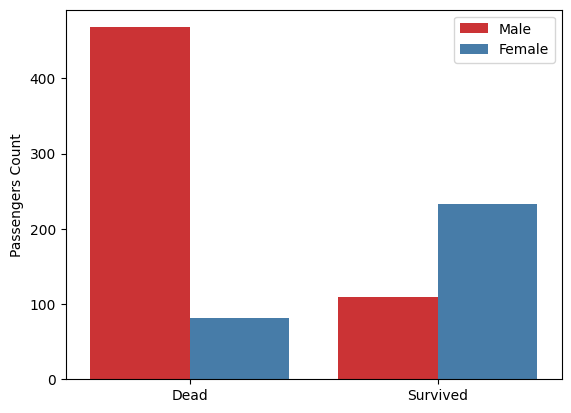

In [17]:
sns.countplot(x='Survived', data=df_1, hue='Sex', palette='Set1')
plt.legend(labels=["Male","Female"])
plt.xlabel('')
plt.ylabel('Passengers Count')
plt.xticks(ticks=np.arange(0,2,1), labels=["Dead", "Survived"])
plt.show()

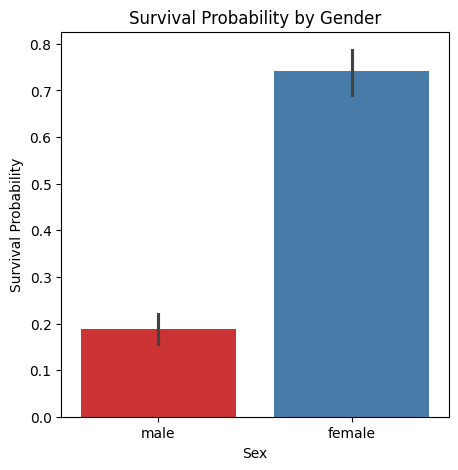

In [18]:
fig, ax = plt.subplots(figsize=(5,5))

sns.barplot(x = 'Sex', y ='Survived', data = df_1, palette = "Set1")
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Gender')
plt.show()

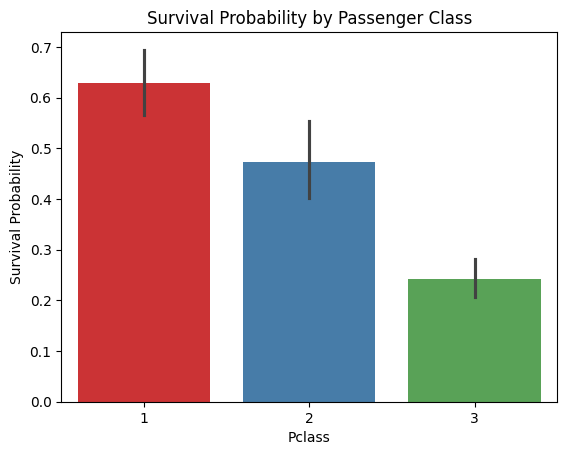

In [19]:
# Visualising survival probability per passenger's class
sns.barplot(x = 'Pclass', y ='Survived', data = df_1, palette='Set1')
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Passenger Class')
plt.show()

In [20]:
df_1["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

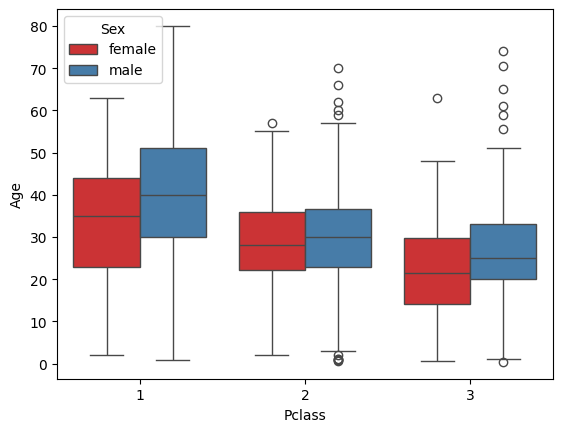

In [21]:
sns.boxplot(x='Pclass', y='Age', data=df_1, hue='Sex', palette='Set1')
plt.show()

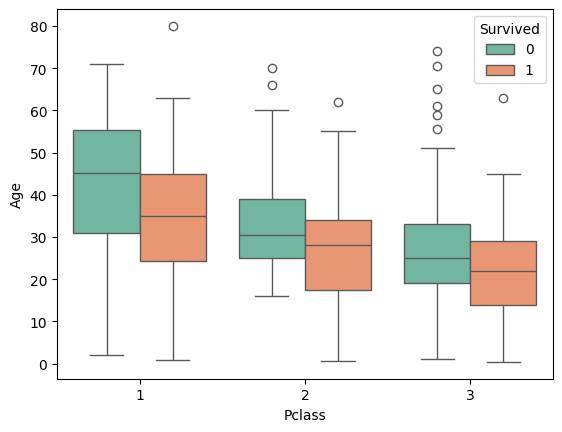

In [22]:
# Visualizing Age per Sex by survival
sns.boxplot(x='Pclass', y='Age', data=df_1, hue='Survived', palette='Set2')
plt.show()

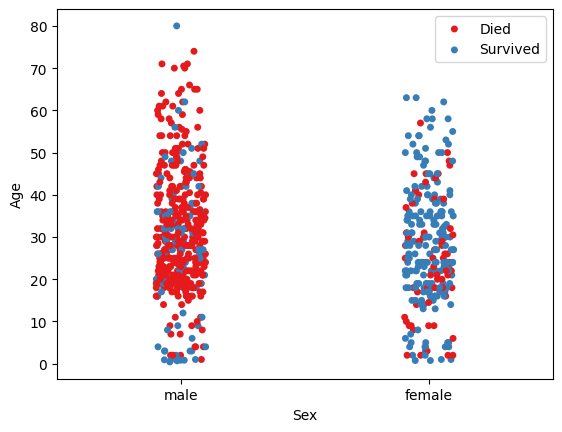

In [23]:
sns.stripplot(x='Sex', y='Age', data=df_1, hue='Survived', palette='Set1', jitter=True)
plt.legend(labels=['Died','Survived'])
plt.show()

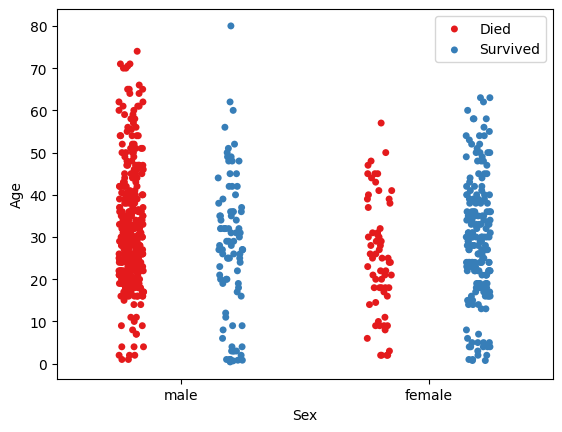

In [24]:
sns.stripplot(x='Sex', y='Age', data=df_1, hue='Survived', palette='Set1', jitter=True, dodge=True)
plt.legend(labels=['Died','Survived'])
plt.show()

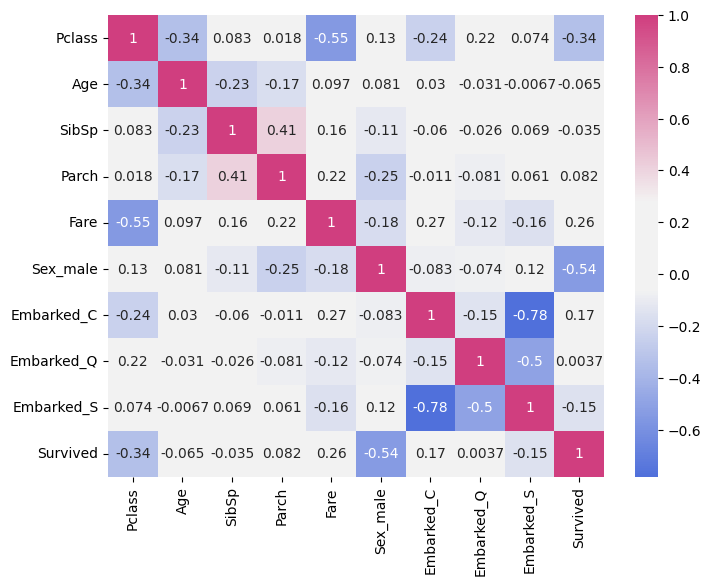

In [25]:
# Correlation analysis
dependable= 'Survived'
cmap = sns.diverging_palette(h_neg=260,h_pos=350,n=7,s=75,l=50, sep=50, center="light", as_cmap=True)
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(pd.concat([df.drop(dependable,axis=1), df[dependable]],axis=1).corr(), annot=True, cmap=cmap)


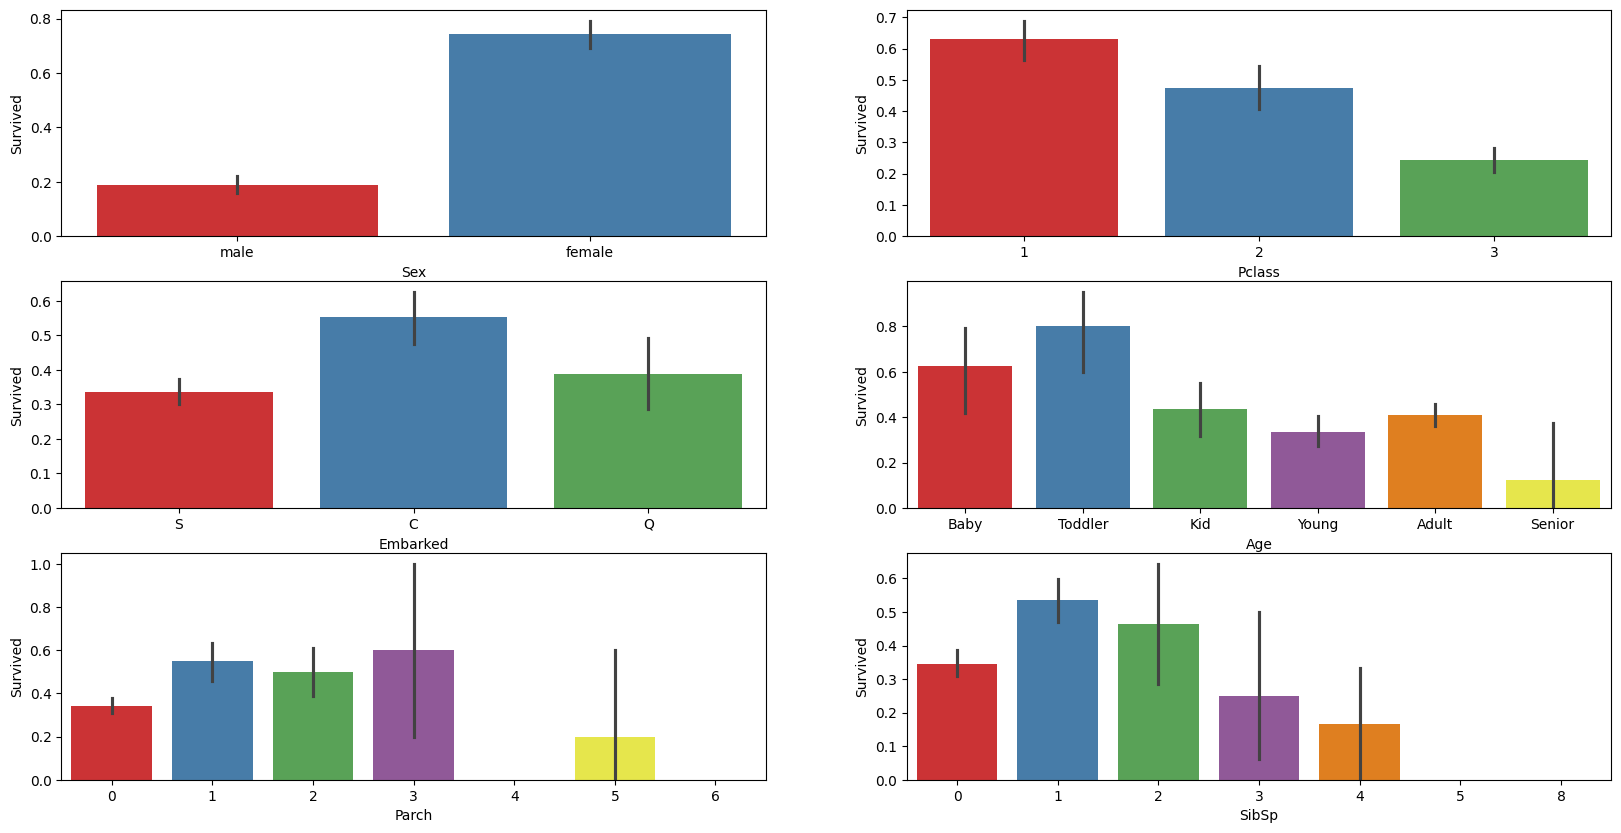

In [26]:
# Creating a grid plot with features versus survival, to make age more significant for visualisation (to many bars) I will devide ages in groups
# Using plt.style.use

bins = [0, 2, 5, 17, 25, 65, 80]
labels = ['Baby', 'Toddler', 'Kid', 'Young', 'Adult', 'Senior']
df_1['Age'] = pd.cut(df_1['Age'], bins = bins, labels=labels)

number_rows = 3
number_colums = 2
fig = plt.figure(figsize=(20,10))
ax= fig.subplots(number_rows, number_colums)

plt.subplot(321)
sns.barplot(x = 'Sex', y = 'Survived', data = df_1, palette='Set1')
plt.subplot(322)
sns.barplot(x = 'Pclass', y = 'Survived', data = df_1, palette='Set1')
plt.subplot(323)
sns.barplot(x = 'Embarked', y = 'Survived', data = df_1, palette='Set1')
plt.subplot(324)
sns.barplot(x = 'Age', y = 'Survived', data = df_1, palette='Set1')
plt.subplot(325)
sns.barplot(x = 'Parch', y = 'Survived', data = df_1, palette='Set1')
plt.subplot(326)
sns.barplot(x = 'SibSp', y = 'Survived', data = df_1, palette='Set1')
plt.show()

#### LOGISTIC REGRESSION

In [27]:
df.head(2)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,0,1
1,1,1,38.0,1,0,71.2833,0,1,0,0


In [28]:
# Defyning the X and y and checking shape and type
X = df.iloc[:, 1:10].values
y = df.iloc[:, 0].values
print(X.shape)
print(y.shape)
print(type(X))
print(type(y))

(891, 9)
(891,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [29]:
# Split the data
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size= 1/4, random_state=1)

In [30]:
# Normalisation of the data
# Standard scaler
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

In [31]:
# Fitting the model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [32]:
# Making a prediction
y_pred = log_reg.predict(X_test)

In [33]:
# Get results in a data frame
result_log = {'Actual survival': y_test, 'Predicted survival': y_pred}
output= pd.DataFrame(result_log)
output


,Actual survival,Predicted survival
0,1,1
1,0,0
2,1,1
3,0,1
4,1,1
...,...,...
218,1,1
219,0,0
220,1,0
221,0,0


In [34]:
# Calculate accuracy with accuracy_score
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7937219730941704


In [35]:
# Compute confusion matrix to evaluate the accuracy.
conf_mat =confusion_matrix(y_test, y_pred)
conf_mat

# C(0,0) = count of true negative
# C(1,0) = count of false negative
# C(1,1) = count of true positive
# C(0,1) = count of false positive

array([[111,  17],
       [ 29,  66]], dtype=int64)

In [36]:
accuracy = (conf_mat[0][0] +conf_mat[1][1]) / (conf_mat[0][0] +conf_mat[1][1]+conf_mat[0][1] +conf_mat[1][0])
accuracy

0.7937219730941704

#### DECISION TREE and Label encoding

In [37]:
df_2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [38]:
# DROP UNWANTED FEATURES
columns_to_drop = ['PassengerId', 'Name', 'Cabin', 'Ticket']
df_2 = df_2.drop(columns=columns_to_drop)

In [39]:
# Handling missing values like for logistic regression
df_2['Age'].fillna(df_2['Age'].median(), inplace=True)
df_2['Fare'].fillna(df_2['Fare'].median(), inplace=True)
# Adding 2 missing values as 'S', the biggest category
df = df.fillna({'Embarked' : 'S'})

In [40]:
df_2.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [41]:
# Label encoder
encoder = LabelEncoder()

# Encode all the variables in the dataset
survived_encoded = encoder.fit_transform(df_2.iloc[:, 0])
class_encoded = encoder.fit_transform(df_2.iloc[:, 1])
sex_encoded = encoder.fit_transform(df_2.iloc[:, 2])
age_encoded = encoder.fit_transform(df_2.iloc[:, 3])
sibsp_encoded = encoder.fit_transform(df_2.iloc[:, 4])
parch_encoded = encoder.fit_transform(df_2.iloc[:, 5])
fare_encoded = encoder.fit_transform(df_2.iloc[:, 6])
embarked_encoded = encoder.fit_transform(df_2.iloc[:, 7])

In [42]:
# Combine the encoded data
data = list(zip(survived_encoded, class_encoded, sex_encoded, age_encoded, sibsp_encoded, parch_encoded, fare_encoded, embarked_encoded))

In [43]:
data = pd.DataFrame(data, columns=['Survived','Pclass','Sex','Age', 'SibSp', 'Parch','Fare','Embarked'])
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,2,1,28,1,0,18,2
1,1,0,0,51,1,0,207,0
2,1,2,0,34,0,0,41,2
3,1,0,0,47,1,0,189,2
4,0,2,1,47,0,0,43,2


In [44]:
# split the data
data_to_use =data.iloc[:, 1:8]
data_to_target = data.iloc[:,0]

In [45]:
X_train_2, X_test_2, y_train_2, y_test_2 =train_test_split(data_to_use, data_to_target, test_size=0.30, random_state=32)

In [46]:
# decision tree
# gini
# max depth
# entropy

## gini
decision_gini = DecisionTreeClassifier()

## max depth
decision_depth = DecisionTreeClassifier(max_depth=5)

## entropy
decision_entropy = DecisionTreeClassifier(criterion='entropy')

In [47]:
# fitting the model
decision_gini.fit(X_train_2, y_train_2)

DecisionTreeClassifier()

In [48]:
# fitting the model
decision_depth.fit(X_train_2, y_train_2)

DecisionTreeClassifier(max_depth=5)

In [49]:
# fitting the model
decision_entropy.fit(X_train_2, y_train_2)

DecisionTreeClassifier(criterion='entropy')

In [50]:
# Make prediction and evaluate

y_pred_gini = decision_gini.predict(X_test_2)
y_pred_depth = decision_depth.predict(X_test_2)
y_pred_entropy = decision_entropy.predict(X_test_2)

In [51]:
#Printing accuracy
print('Accuracy(gini):', metrics.accuracy_score(y_test_2, y_pred_gini))
print('Accuracy(depth):', metrics.accuracy_score(y_test_2, y_pred_depth))
print('Accuracy(entropy):', metrics.accuracy_score(y_test_2, y_pred_entropy))

Accuracy(gini): 0.7686567164179104
Accuracy(depth): 0.7873134328358209
Accuracy(entropy): 0.7611940298507462


In [52]:
# Model accuracy comparison
# CREATING A FUNCTION FOR ACCURACY

def model_accuracy(lr, X_test, y_test, model_name):
    y_pred = lr.predict(X_test)
    Accuracy = metrics.accuracy_score(y_test, y_pred)
    return pd.DataFrame([Accuracy], index=['Accuracy'], columns=[model_name])

In [53]:
# Calculating accuracy for each Model and and showing it in a dataframe
Gini_model=model_accuracy(decision_gini, X_test_2,y_test_2, 'Decision tree(GINI)')
Max_depth_model=model_accuracy(decision_depth, X_test_2,y_test_2, 'Decision tree(Depth)')
Entropy_model=model_accuracy(decision_depth, X_test_2,y_test_2, 'Decision tree(Entropy)')
Evaluation_df = pd.concat([Gini_model,Max_depth_model,Entropy_model, model_accuracy(log_reg, X_test,y_test, 'Logistic Regression')], axis=1)
Evaluation_df

,Decision tree(GINI),Decision tree(Depth),Decision tree(Entropy),Logistic Regression
Accuracy,0.768657,0.787313,0.787313,0.793722


#### Preparing the test data


In [54]:
# The test data will have to be consistent with the data I trained the models with so I will:
# treat missing values, drop values I havent fit in the models, encode features 
X_test_final.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [55]:
X_test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [56]:
#Filling up missing values with median
X_test_final['Age'].fillna(X_test_final['Age'].median(), inplace=True)
X_test_final['Fare'].fillna(X_test_final['Fare'].median(), inplace=True)

In [57]:
# DROP UNWANTED FEATURES
columns_to_drop = ['PassengerId', 'Name', 'Cabin', 'Ticket']
X_test_final = X_test_final.drop(columns=columns_to_drop)

In [58]:
# ONE-HOT CODING
# Hot-Encoding the Categorical Columns to transform them in numerical
X_test_final = pd.get_dummies(X_test_final, columns=['Sex'], drop_first=True, dtype = 'int')
X_test_final = pd.get_dummies(X_test_final, columns=['Embarked'], dtype = 'int')

#### Running test data through the model and creating submission file

In [59]:
y_pred_final = log_reg.predict(X_test_final)

In [65]:
print(type())
print(type(X_test_final_1['PassengerId']))y_pred_final

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [75]:
Submission = pd.DataFrame(X_test_final_1['PassengerId'])
Submission.insert(1, "Survived", y_pred_final, True)
Submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [74]:
Submission.to_csv('Submission.csv', index=False)